In [1]:
import os
import sys 
import math
# Import GPyTorch
import gpytorch

import numpy as np # linear algebra
from scipy.stats import randint
import matplotlib.pyplot as plt # this is used for the plot the graph 
%matplotlib inline
from tqdm import notebook
from scipy import stats
from scipy.interpolate import interp1d
import time

import torch

import gpytorch
# Import exact GP model


from gpytorch.models import ApproximateGP
from gpytorch.variational import CholeskyVariationalDistribution
from gpytorch.variational import VariationalStrategy

# Import GPyTorch mean and covariance kernel functions
from gpytorch.means import ConstantMean, LinearMean
from gpytorch.kernels import ScaleKernel, RBFKernel, PeriodicKernel, SpectralMixtureKernel


# Import GPyTorch distribution and likelihood
# MultivariateNormal a multivariate normal random variable
from gpytorch.distributions import MultivariateNormal
# GPyTorch likelihood specifies the mapping from latent function values observed labels
from gpytorch.likelihoods import GaussianLikelihood
# module that calculates the exact marginal log likelihood (MLL)
from gpytorch.mlls import ExactMarginalLogLikelihood

from torch.utils.data import TensorDataset, DataLoader



import tqdm





### simulate data

In [2]:
np.random.seed(2020)

# generate mu, gaussian
mu=np.random.normal(scale=2,size=1000)

# generate sd, uniform
sig=np.random.uniform(0.5,2.5,size=1000)


# the full design matrix
x=np.c_[mu,sig]


y=np.random.normal(loc=mu,scale=sig,size=(1000))


train_x=x[:700,:]
train_y=y[:700]

test_x=x[700:,:]
test_y=y[700:]

ntrain=len(train_x)
ntest=len(test_x)

# Convert to PyTorch tensors and place
train_y = torch.from_numpy(train_y).float()
train_x = torch.from_numpy(train_x).float()
test_y = torch.from_numpy(test_y).float()
test_x = torch.from_numpy(test_x).float()


### PPGPR Model

https://arxiv.org/pdf/1910.07123.pdf

In [3]:
class GPModel(ApproximateGP):
    def __init__(self, inducing_points):
        variational_distribution = CholeskyVariationalDistribution(inducing_points.size(0))
        variational_strategy = VariationalStrategy(self, inducing_points, variational_distribution, learn_inducing_locations=True)
        super(GPModel, self).__init__(variational_strategy)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

### Single Evaluation

In [6]:
#data loader
train_dataset = TensorDataset(train_x, train_y)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

inducing_points = train_x[:500] #training set is small, all set as inducing point
model = GPModel(inducing_points=inducing_points)
likelihood = gpytorch.likelihoods.GaussianLikelihood()

if torch.cuda.is_available():
    model = model.cuda()
    likelihood = likelihood.cuda()

model.train()
likelihood.train()

optimizer = torch.optim.Adam([
    {'params': model.parameters()},
    {'params': likelihood.parameters()},
], lr=0.01)

# Our loss object. We're using the VariationalELBO
mll = gpytorch.mlls.PredictiveLogLikelihood(likelihood, model, num_data=train_y.numel())

epochs_iter = tqdm.notebook.tqdm(range(300), desc="Epoch")
for i in epochs_iter:
    # Within each iteration, we will go over each minibatch of data
    minibatch_iter = tqdm.notebook.tqdm(train_loader, desc="Minibatch", leave=False)
    for x_batch, y_batch in minibatch_iter:
        optimizer.zero_grad()
        output = model(x_batch)
        loss = -mll(output, y_batch)
        minibatch_iter.set_postfix(loss=loss.item())
        loss.backward()
        optimizer.step()
        
        
model.eval()
likelihood.eval()
with torch.no_grad():
    preds = model(test_x)

ppgprmu=preds.mean.detach().numpy()
ppgprstd=preds.stddev.detach().numpy()   

            

#### Interval width

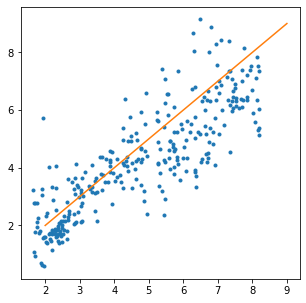

In [7]:
#generate confidence interval estimated mean and std
ppgprwidth=stats.norm.ppf(0.95)*2*ppgprstd

l90=(stats.norm.ppf(0.5-0.9/2.)*ppgprstd+ppgprmu)
r90=(stats.norm.ppf(0.5+0.9/2.)*ppgprstd+ppgprmu)
np.mean((test_y.ravel().numpy()<r90.ravel())*(test_y.ravel().numpy()>l90.ravel()))    

## 90% interval width
plt.figure(figsize=(5,5))
plt.plot(sig[700:].ravel()*2.*1.64,ppgprwidth,'.')
plt.plot([2,9],[2,9])
#np.save('ppgprwidth',ppgprwidth)

#### Recover of true cdf

In [8]:
#generate sample
np.random.seed(2020)
samps=np.random.choice(len(test_x),3)
#the mean and sd for the random sample
musd=x[700:][samps]
yrange=np.linspace(musd[:,0]-4*musd[:,1],musd[:,0]+4*musd[:,1],5000)

## mean and sd for en sample
ppgprmusd=np.c_[ppgprmu,ppgprstd][samps]

In [9]:
musd

array([[ 1.67091651,  1.66674477],
       [-1.34299445,  1.77077775],
       [-1.40733603,  2.09394208]])

/Users/tz/venv/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  after removing the cwd from sys.path.


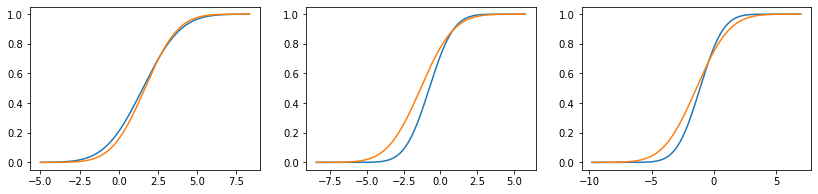

In [11]:
plt.figure(figsize=(14,3))
plt.subplot(131)

plt.subplot(1,3,1)
tcdf=stats.norm.cdf((yrange[:,0]-musd[0,0])/musd[0,1])
ppgprcdf=stats.norm.cdf((yrange[:,0]-ppgprmusd[0,0])/ppgprmusd[0,1])
plt.plot(yrange[:,0],ppgprcdf)
plt.plot(yrange[:,0],tcdf)

plt.subplot(1,3,2)
tcdf=stats.norm.cdf((yrange[:,1]-musd[1,0])/musd[1,1])
ppgprcdf=stats.norm.cdf((yrange[:,1]-ppgprmusd[1,0])/ppgprmusd[1,1])
plt.plot(yrange[:,1],ppgprcdf)
plt.plot(yrange[:,1],tcdf)

plt.subplot(1,3,3)
tcdf=stats.norm.cdf((yrange[:,2]-musd[2,0])/musd[2,1])
ppgprcdf=stats.norm.cdf((yrange[:,2]-ppgprmusd[2,0])/ppgprmusd[2,1])
plt.plot(yrange[:,2],ppgprcdf)
plt.plot(yrange[:,2],tcdf)

### Ten Replications to evaluate the hard metrics

In [4]:
##function to create replication
def rep_iter(x,y,frac=0.3):
    n=len(x)
    ntest=int(np.floor(frac*n))
    allidx=np.random.permutation(n)
    trainidx= allidx[ntest:]
    testidx= allidx[:ntest]
    return x[trainidx],y[trainidx],x[testidx],y[testidx]
    

In [5]:
#initialize the metric
ppgprll=[]
ppgprcal=[]
ppgpr90=[]
ppgprmae=[]

In [6]:
np.random.seed(2021)
for a in range(10):
    train_x,train_y,test_x,test_y=rep_iter(x,y)
    ntrain=len(train_x)
    ntest=len(test_x)

    # Convert to PyTorch tensors and place
    train_y = torch.from_numpy(train_y).float()
    train_x = torch.from_numpy(train_x).float()
    test_x = torch.from_numpy(test_x).float()
    
    #data loader
    train_dataset = TensorDataset(train_x, train_y)
    train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

    inducing_points = train_x[:500] #training set is small, all set as inducing point
    model = GPModel(inducing_points=inducing_points)
    likelihood = gpytorch.likelihoods.GaussianLikelihood()

    if torch.cuda.is_available():
        model = model.cuda()
        likelihood = likelihood.cuda()

    model.train()
    likelihood.train()

    optimizer = torch.optim.Adam([
        {'params': model.parameters()},
        {'params': likelihood.parameters()},
    ], lr=0.01)

    # Our loss object. We're using the VariationalELBO
    mll = gpytorch.mlls.PredictiveLogLikelihood(likelihood, model, num_data=train_y.numel())

    epochs_iter = tqdm.notebook.tqdm(range(300), desc="Epoch")
    for i in epochs_iter:
        # Within each iteration, we will go over each minibatch of data
        minibatch_iter = tqdm.notebook.tqdm(train_loader, desc="Minibatch", leave=False)
        for x_batch, y_batch in minibatch_iter:
            optimizer.zero_grad()
            output = model(x_batch)
            loss = -mll(output, y_batch)
            minibatch_iter.set_postfix(loss=loss.item())
            loss.backward()
            optimizer.step()


    model.eval()
    likelihood.eval()
    with torch.no_grad():
        preds = model(test_x)

    ppgprmu=preds.mean.detach().numpy()
    ppgprstd=preds.stddev.detach().numpy()   

    
    #####calculate metrics##############

    per=np.linspace(0.02,0.98,8) #quantile to study calibration

    ppgprc=[]

    for i in per:
        lquantile=(stats.norm.ppf(0.5-i/2.)*ppgprstd+ppgprmu)
        rquantile=(stats.norm.ppf(0.5+i/2.)*ppgprstd+ppgprmu)
        ppgprc.append(np.mean((test_y.ravel()<rquantile.ravel())*(test_y.ravel()>lquantile.ravel())))

    ppgprcal.append(np.abs(ppgprc-per).mean())
    
    #ninty
    l90=(stats.norm.ppf(0.5-0.9/2.)*ppgprstd+ppgprmu)
    r90=(stats.norm.ppf(0.5+0.9/2.)*ppgprstd+ppgprmu)
    ppgpr90.append(np.mean((test_y.ravel()<r90.ravel())*(test_y.ravel()>l90.ravel())))
    
    #log likelihood
    low=np.quantile(test_y,0.05)
    high=np.quantile(test_y,0.95)
    itv=np.linspace(low,high,9)
    itv=np.append(-np.infty,itv)
    itv=np.append(itv,np.infty)
    #outcome1 belongs to which interval
    id=np.zeros(len(test_y))
    for i in range(10):
        id=id+1*(test_y.ravel()>itv[i+1])
    id=id.astype('int')

    l=(itv[id]-ppgprmu)/ppgprstd
    r=(itv[id+1]-ppgprmu)/ppgprstd
    prtmp=stats.norm.cdf(r)-stats.norm.cdf(l)
    ll_est=np.log(prtmp)
    ppgprll.append(ll_est.mean())
    
    #mae
    #ppgprmae.append(np.abs(ppgprmu-test_y.ravel()).mean()) #regular def
    ppgprmae.append(np.abs(ppgprmu-test_x[:,0].numpy()).mean())  #against the ground truth


    




In [7]:
def musd(x):
    print(np.mean(x),np.std(x))

musd(ppgprll)
musd(ppgprcal)
musd(ppgpr90)
musd(ppgprmae)




-1.8199476653989906 0.08459654556042621
0.04034523809523812 0.01374154037845791
0.8333333333333334 0.023570226039551587
0.29952854 0.055230226
